# House Prices - Advanced Regression Techniques

#### [Оглавление](#0-bullet)
#### [1. Загрузка библиотек и данных](#1-bullet)
#### [2. Обзор и анализ данных](#2-bullet)
####   [2.1 Обзор](#2.1-bullet)
####   [2.2 Визуализация](#2.2-bullet)
####  [3. Подготовка данных к обучению](#3-bullet)
####    [3.1 Pipeline](#3.1-bullet)
####  [4. Optuna](#4-bullet)
####  [5. Итоги](#5-bullet)

## 1. Загрузка библиотек и данных<a class="anchor" id="1-bullet"></a>
[назад к оглавлению](#0-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
#Предобработка данных
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_log_error
#Модели
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## 2. Обзор и анализ данных <a class="anchor" id=2-bullet></a>
[назад к оглавлению](#0-bullet)

### 2.1 Обзор данных<a class="anchor" id="2.1-bullet"></a>

In [3]:
columns_na=[features for features in df_train.columns if df_train[features].isnull().sum()>1]
for feature in columns_na:
    print(feature, np.round(df_train[feature].isnull().mean(), 4),  ' % пропущенных значений')

LotFrontage 0.1774  % пропущенных значений
Alley 0.9377  % пропущенных значений
MasVnrType 0.0055  % пропущенных значений
MasVnrArea 0.0055  % пропущенных значений
BsmtQual 0.0253  % пропущенных значений
BsmtCond 0.0253  % пропущенных значений
BsmtExposure 0.026  % пропущенных значений
BsmtFinType1 0.0253  % пропущенных значений
BsmtFinType2 0.026  % пропущенных значений
FireplaceQu 0.4726  % пропущенных значений
GarageType 0.0555  % пропущенных значений
GarageYrBlt 0.0555  % пропущенных значений
GarageFinish 0.0555  % пропущенных значений
GarageQual 0.0555  % пропущенных значений
GarageCond 0.0555  % пропущенных значений
PoolQC 0.9952  % пропущенных значений
Fence 0.8075  % пропущенных значений
MiscFeature 0.963  % пропущенных значений


### ТОП-5 по количеству пропущенных значений:
1. $PoolQC = 0.9952$
2. $MiscFeature = 0.963$
3. $Alley = 0.9377$
4. $Fence = 0.8075$
5. $FireplaceQu = 0.4726$

### 2.2 Визуализация<a class="anchor" id="2.2-bullet"></a>
[назад к оглавлению](#0-bullet)

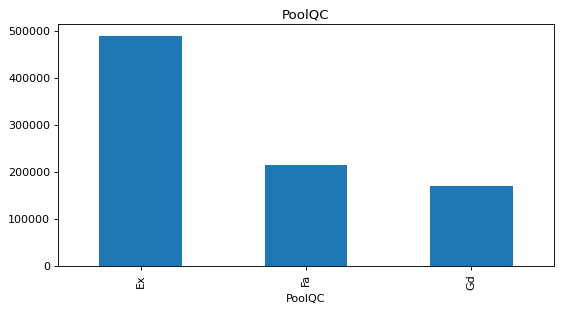

In [4]:
plt.figure(figsize=(8, 4), dpi=80)
df_train.groupby('PoolQC')['SalePrice'].median().plot.bar()
plt.title('PoolQC')
plt.show()

#### Наличие хорошего бассейна значительно увеличивает стоимость жилья

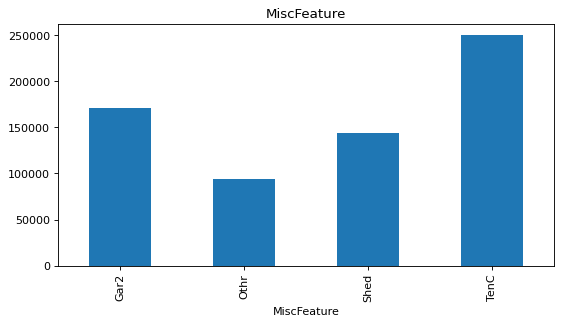

In [5]:
plt.figure(figsize=(8, 4), dpi=80)
df_train.groupby('MiscFeature')['SalePrice'].median().plot.bar()
plt.title('MiscFeature')
plt.show()

#### Наличие дополнительных ништячков типа: гараж, сарай, лифт повышает стоимость недвижимости, но если есть тенисный корт (что-то на богатом), то цена максимальна.

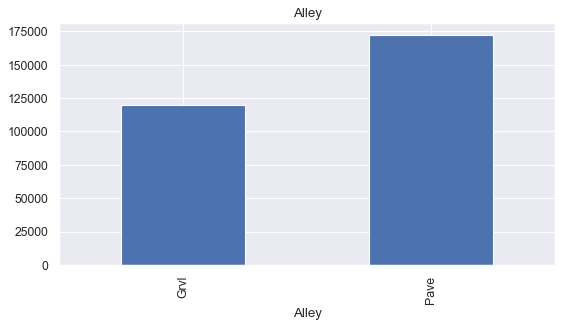

In [113]:
plt.figure(figsize=(8, 4), dpi=80)
df_train.groupby('Alley')['SalePrice'].median().plot.bar()
plt.title('Alley')
plt.show()

#### Наличие вымощенной дороги к жилью значительно повышает стоимость

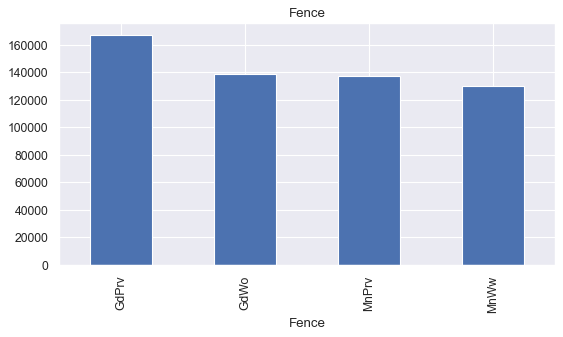

In [114]:
plt.figure(figsize=(8, 4), dpi=80)
df_train.groupby('Fence')['SalePrice'].median().plot.bar()
plt.title('Fence')
plt.show()

#### Наличие забора сильно повышает стоимость недвижимости, особенно если забор "глухой" GdPrv

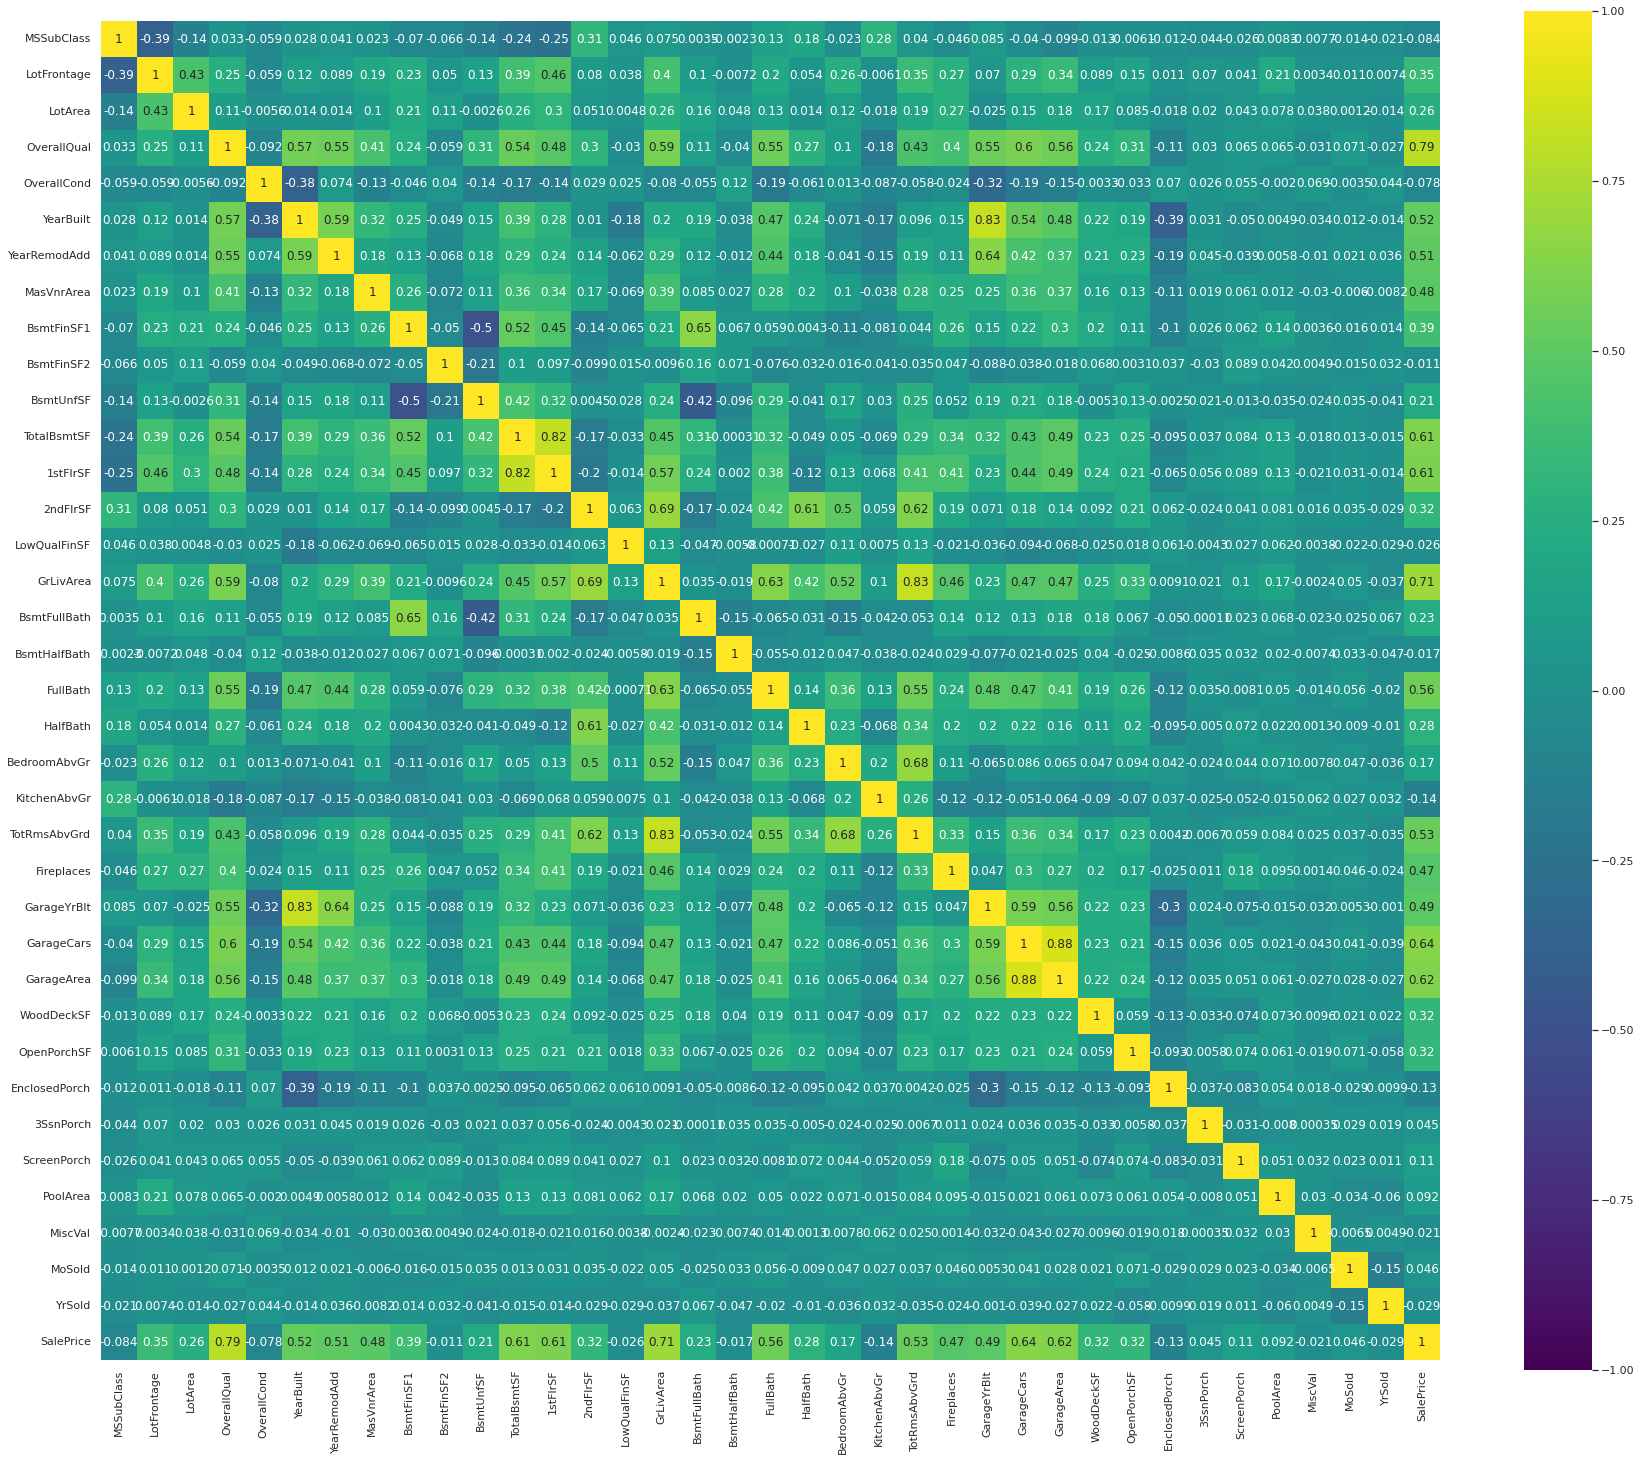

In [12]:
plt.figure(figsize=(30,25))
corr = df_train.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
sns.set(font_scale=1)  
sns.heatmap(corr, cmap='viridis', vmin = -1, vmax=1, robust=True, square=True, annot=True);

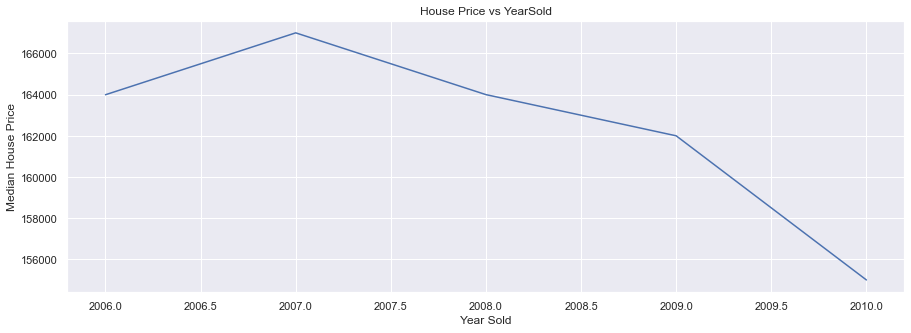

In [115]:
plt.figure(figsize=(15,5))
df_train.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('Median House Price')
plt.title("House Price vs YearSold");

#### Медиана цен падает с каждым годом

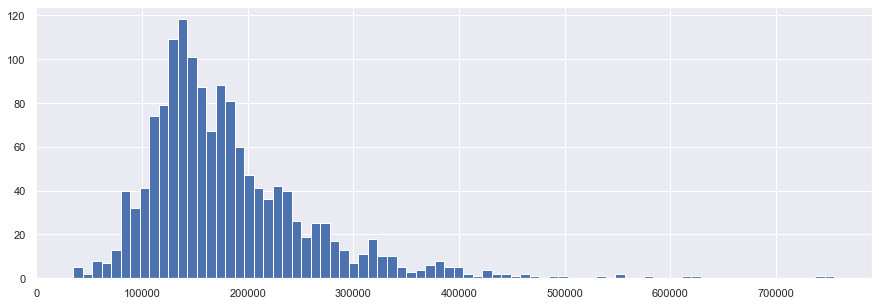

In [16]:
df_train['SalePrice'].hist(bins = 80, figsize=(15,5));

#### Приведенные данные цен имеют тяжелые хвосты, поэтому для нормализации можем перейти к логнормальному распределению.

In [116]:
log_list = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF1', 'BsmtUnfSF', 
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

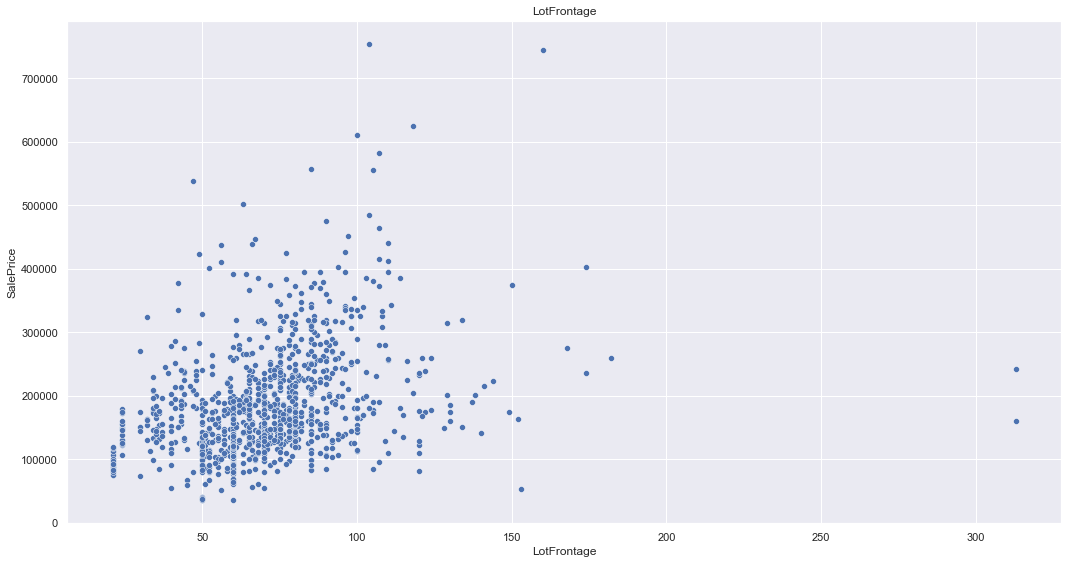

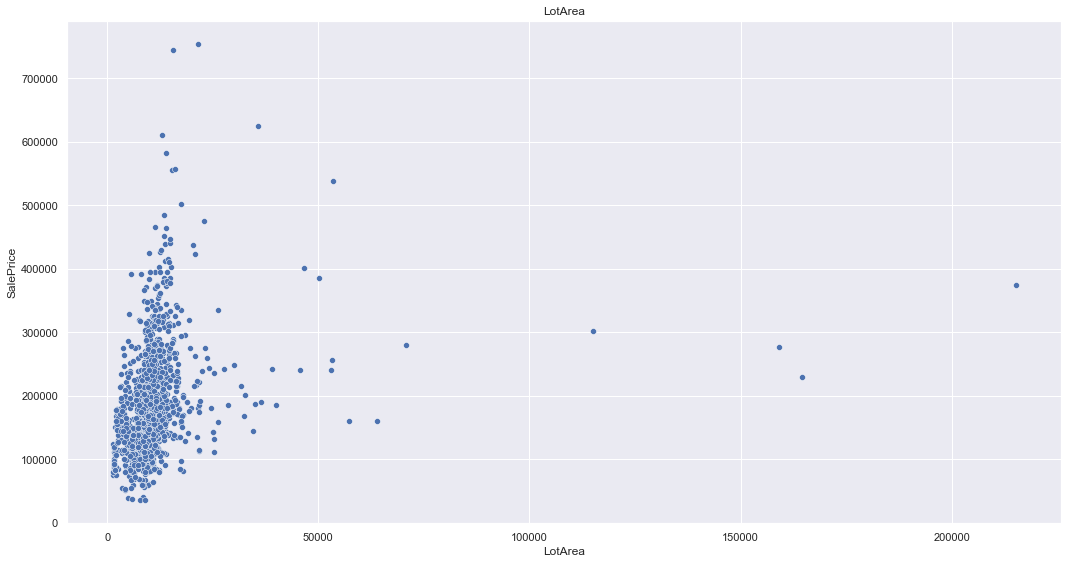

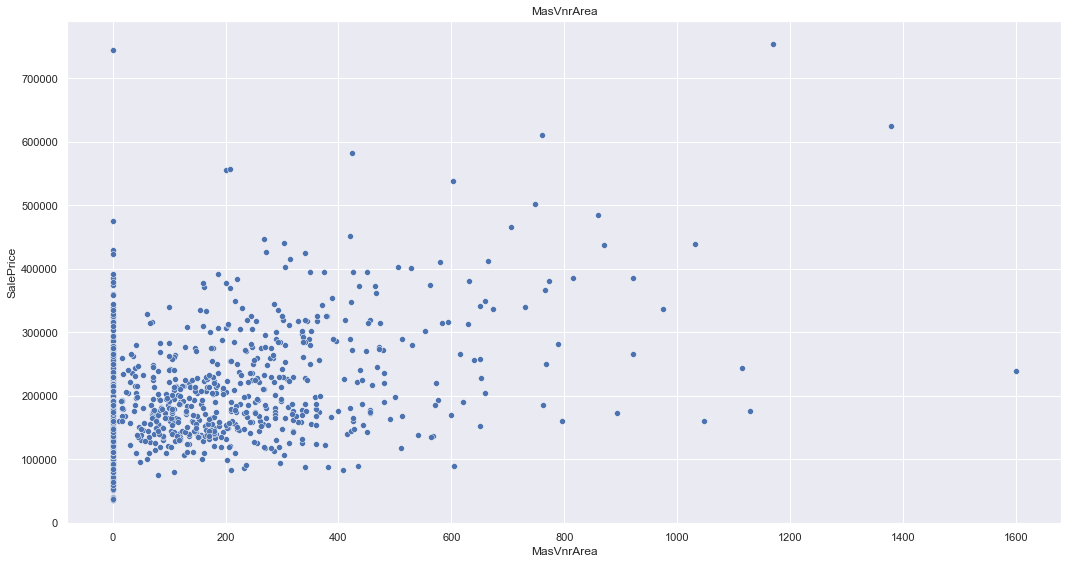

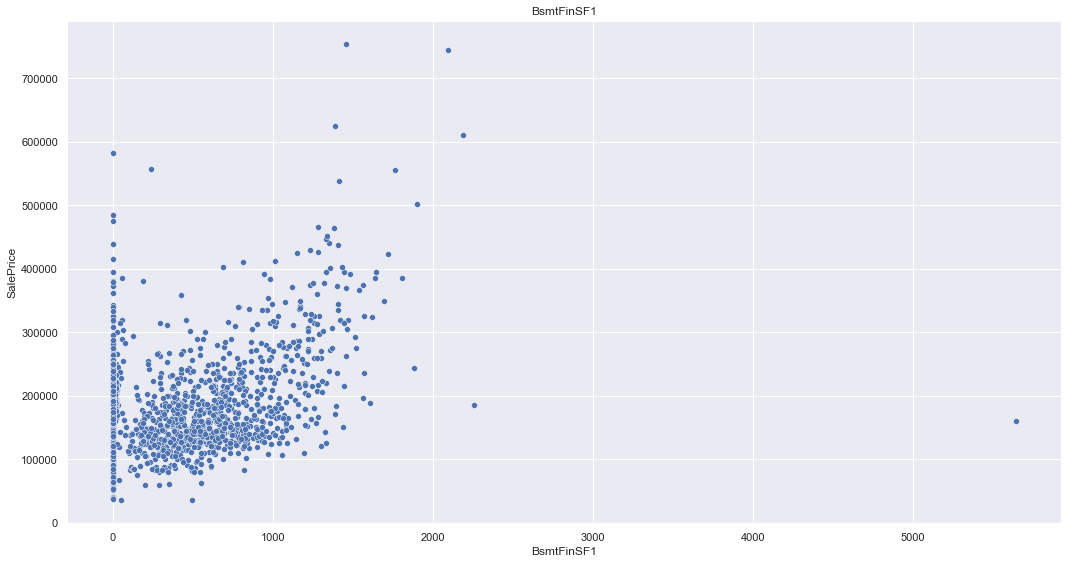

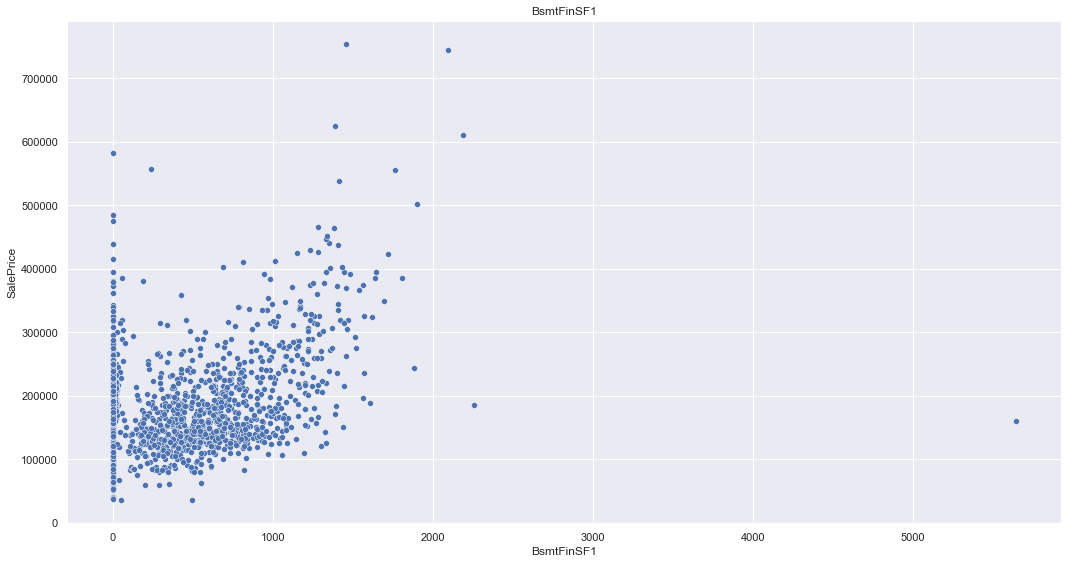

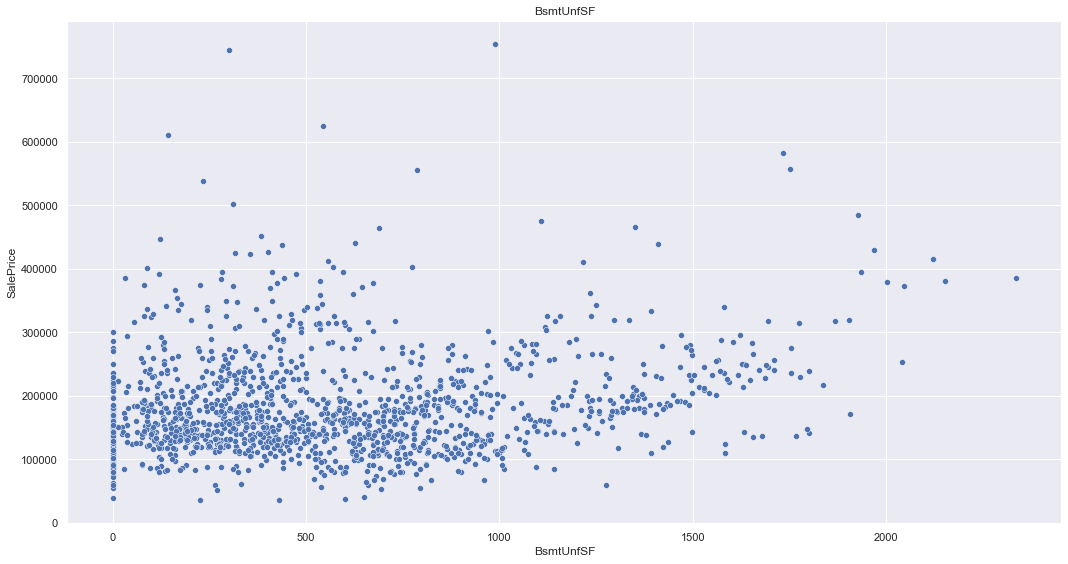

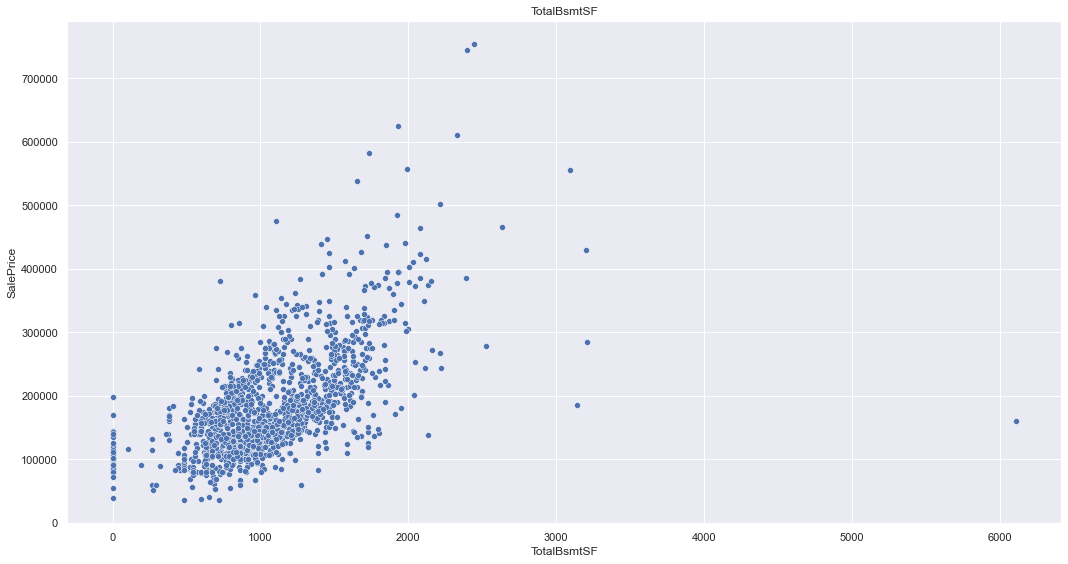

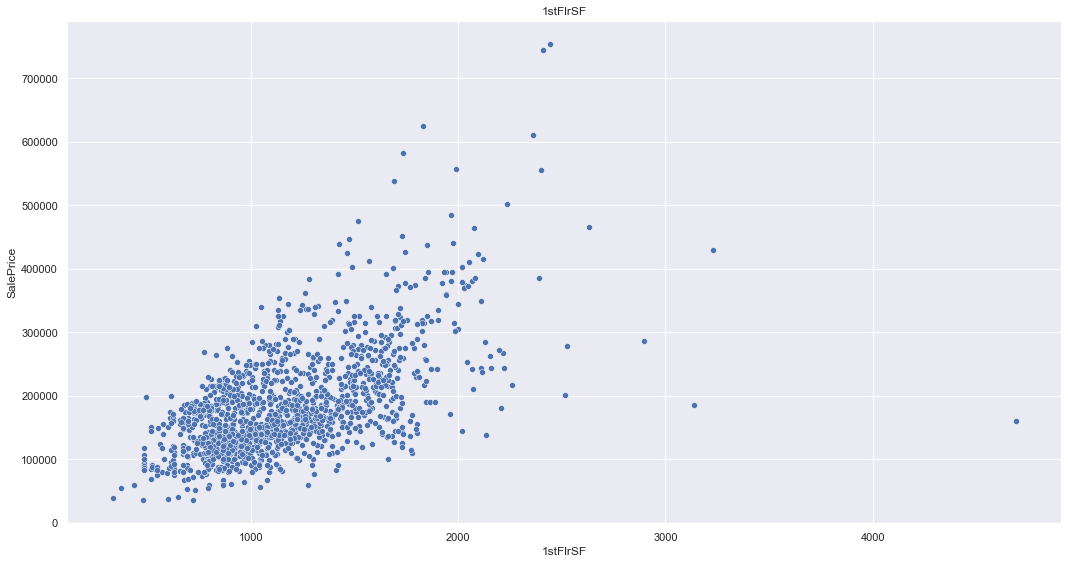

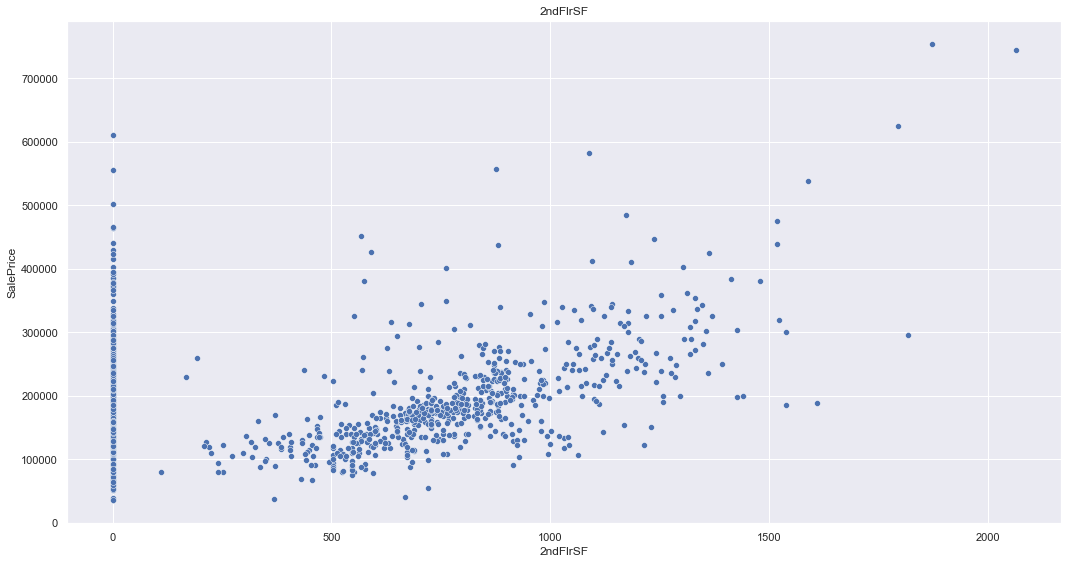

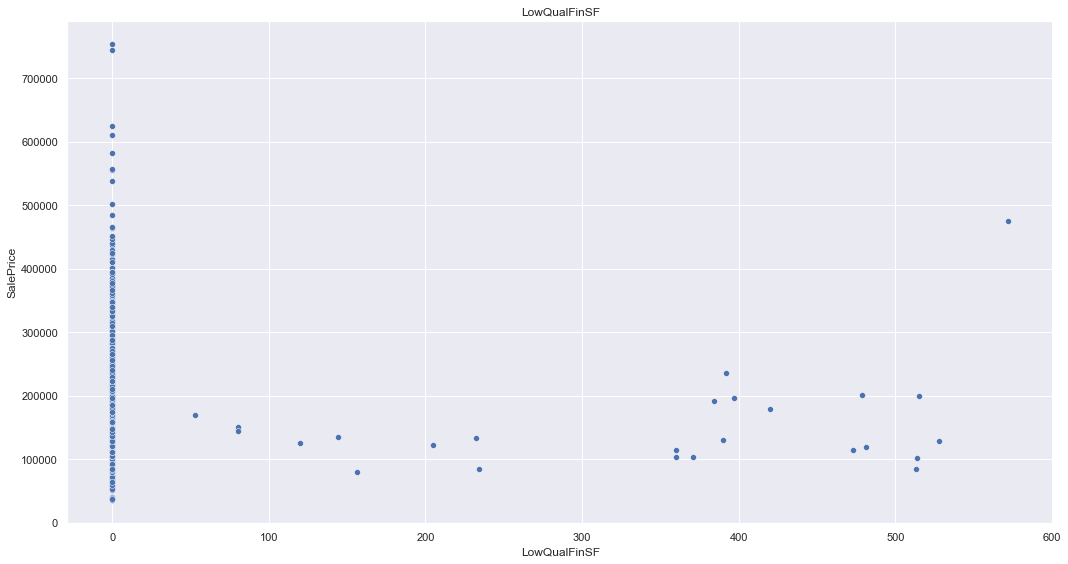

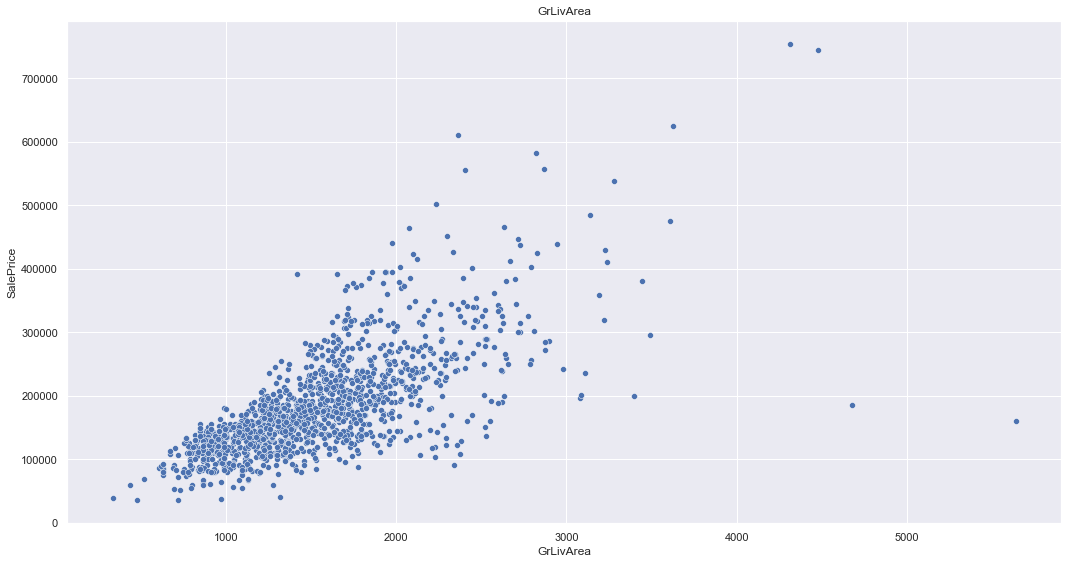

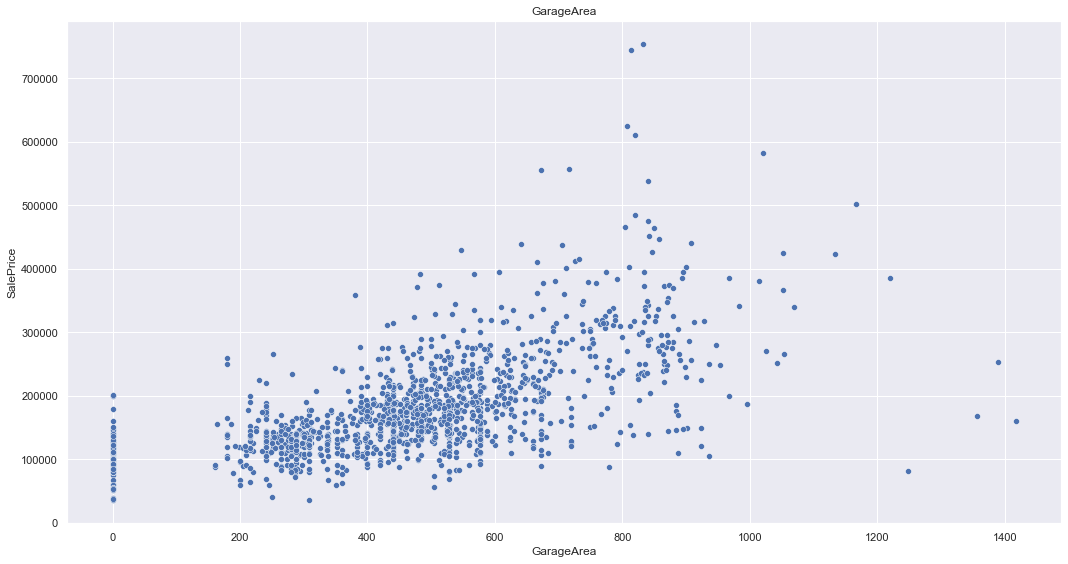

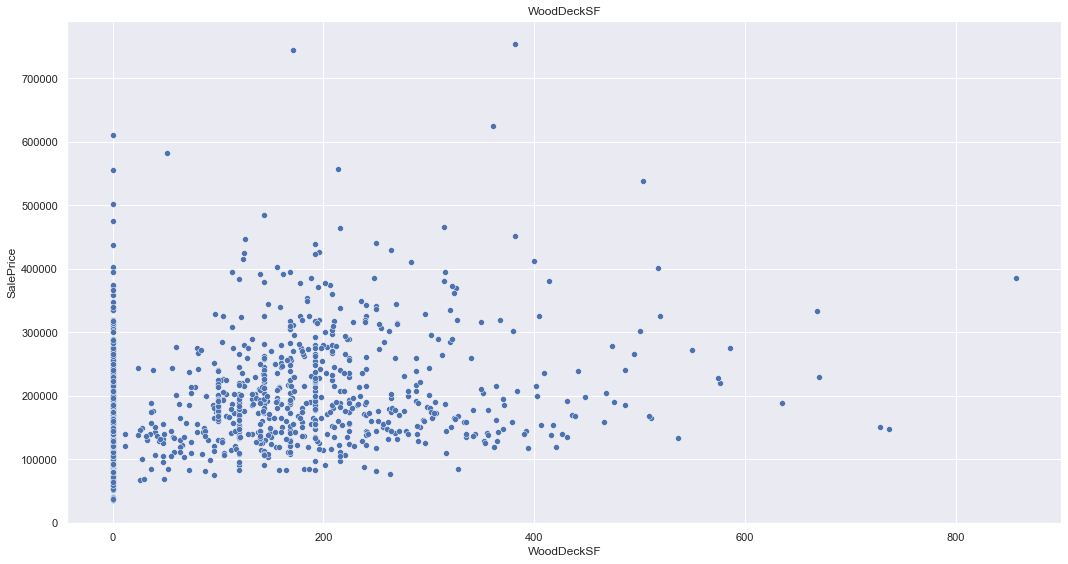

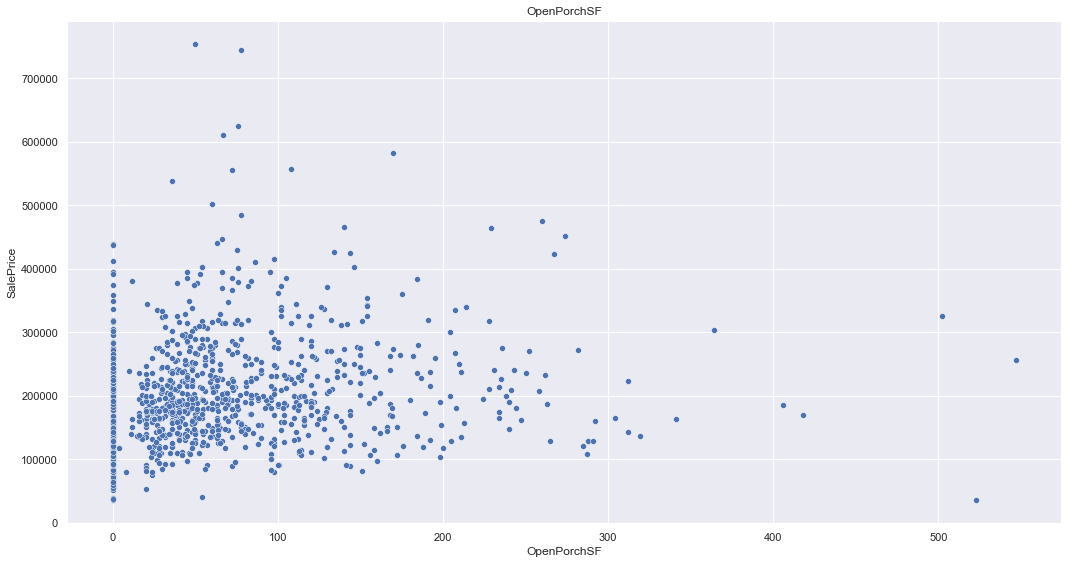

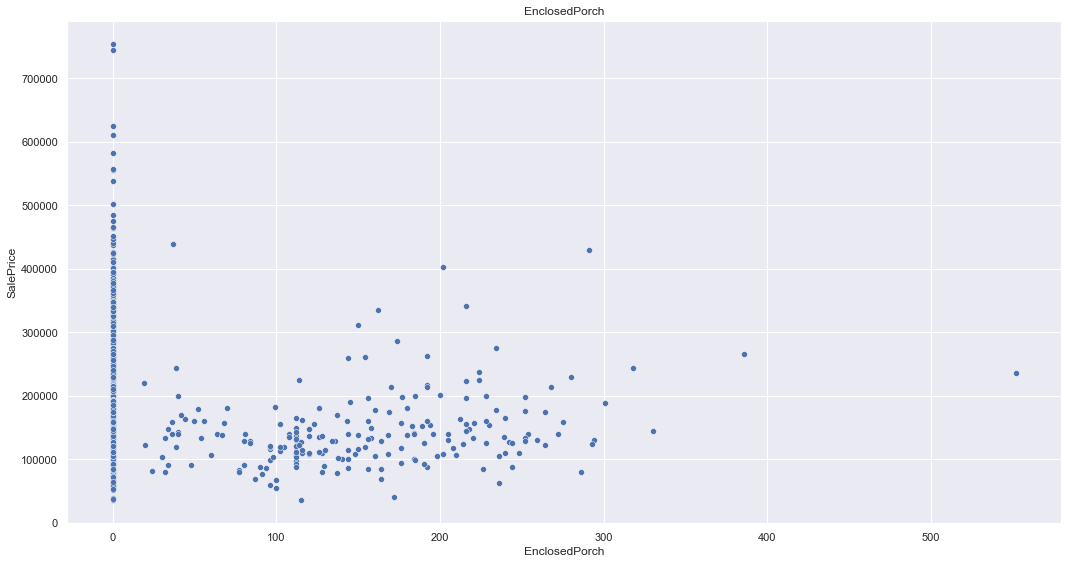

In [133]:
for feature in log_list:
    ax = plt.subplots(figsize=(15,8))
    sns.scatterplot(data=df_train, x=feature, y='SalePrice');
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.tight_layout()

    plt.show()

In [13]:
categ_feature = ['MSSubClass','OverallQual','OverallCond','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','3SsnPorch','PoolArea','MiscVal','MoSold']

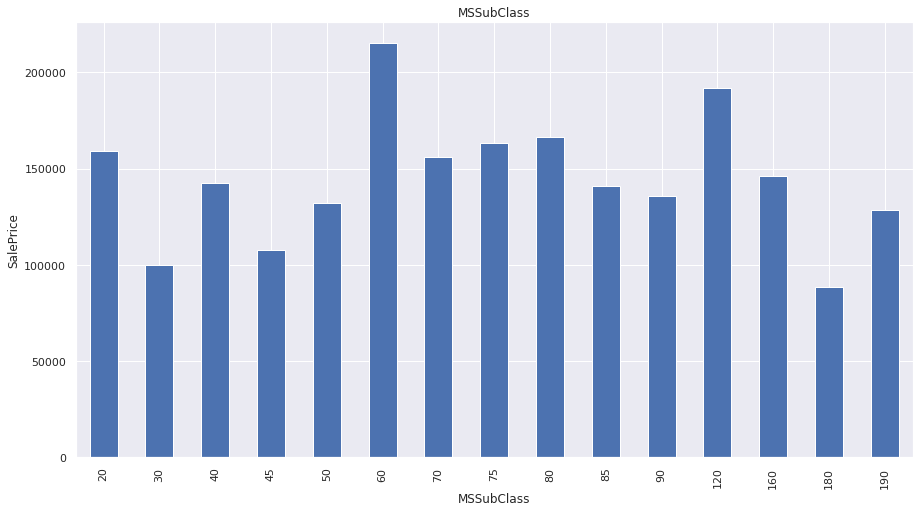

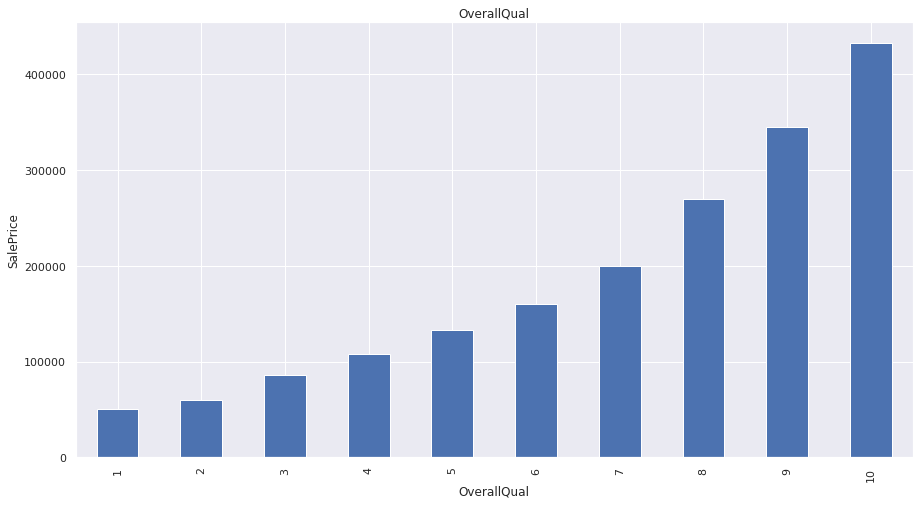

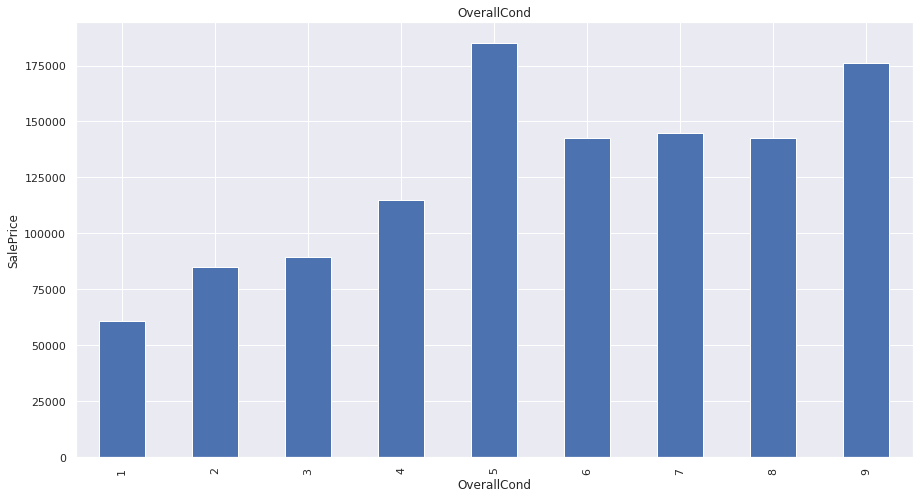

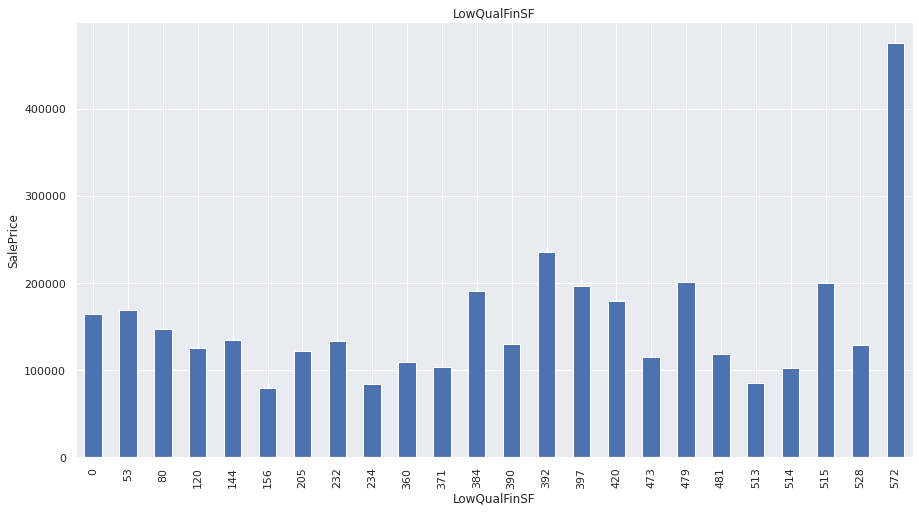

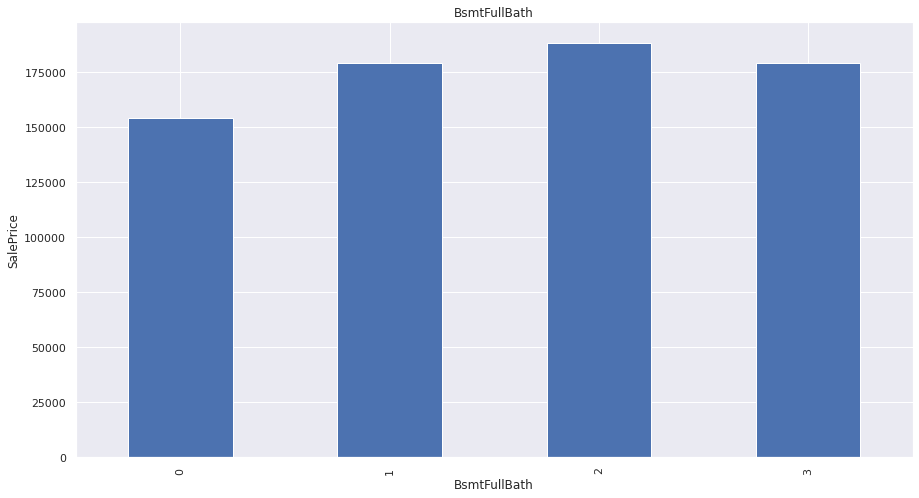

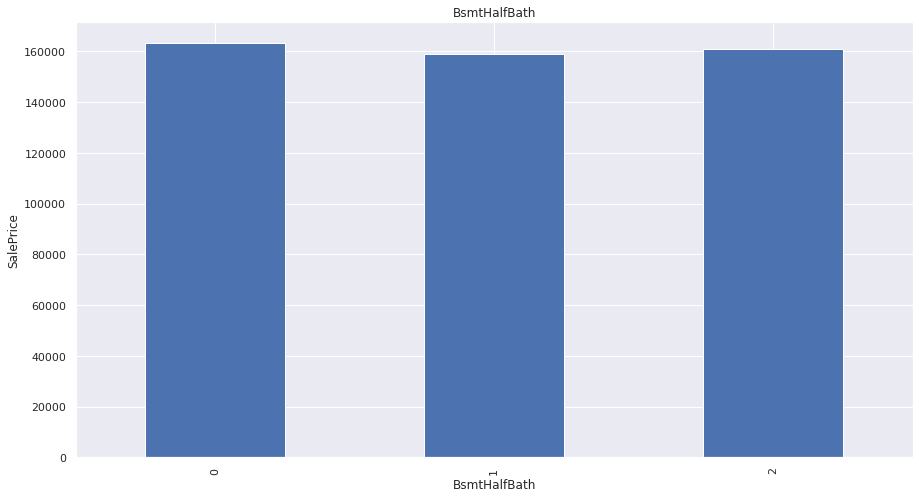

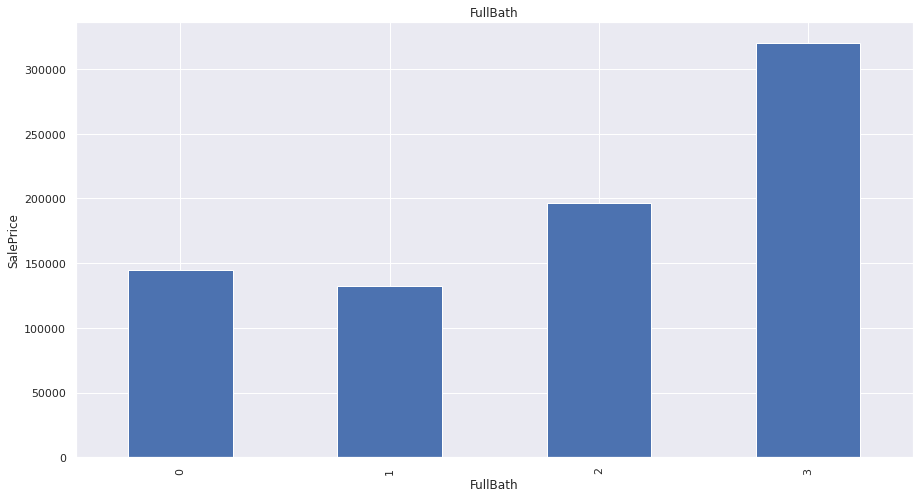

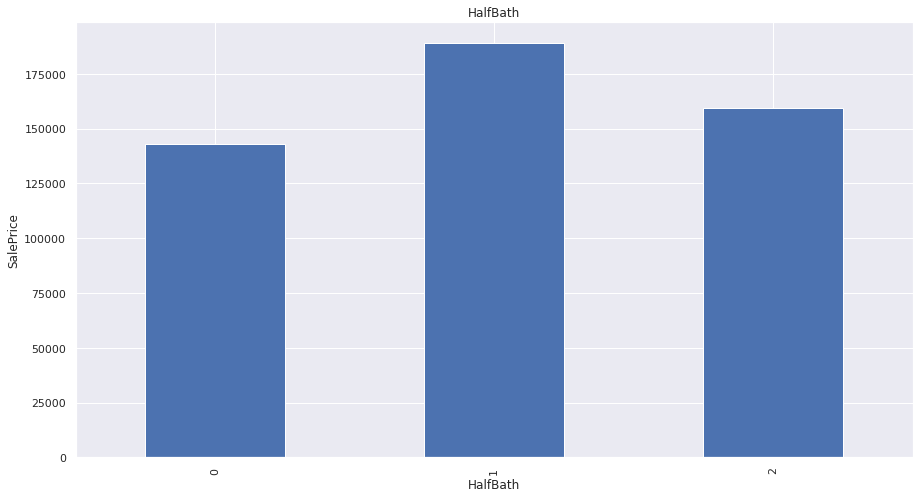

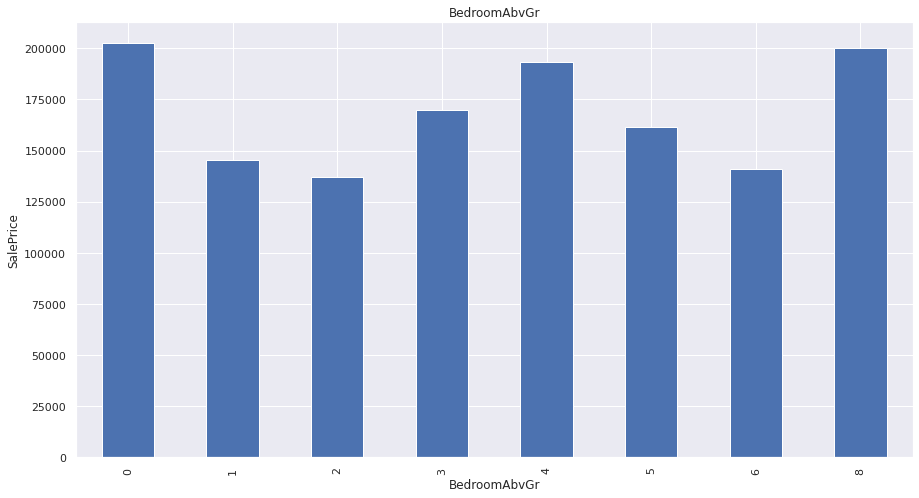

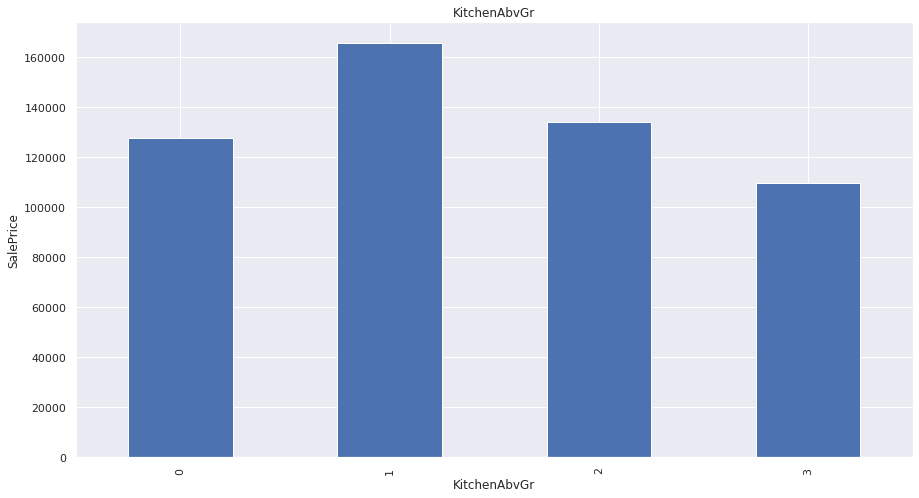

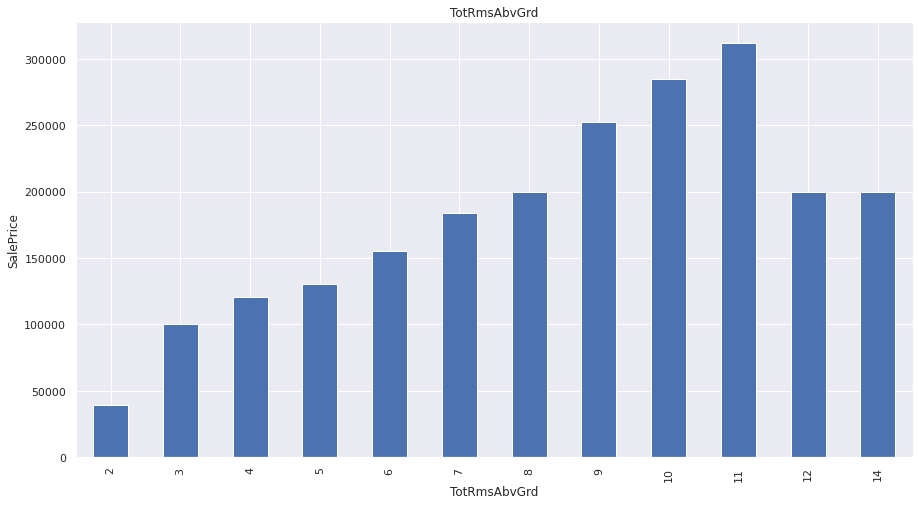

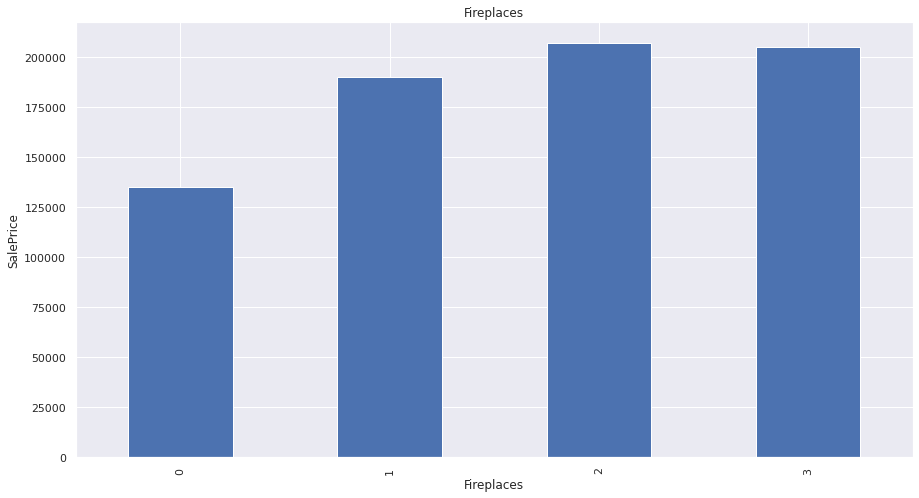

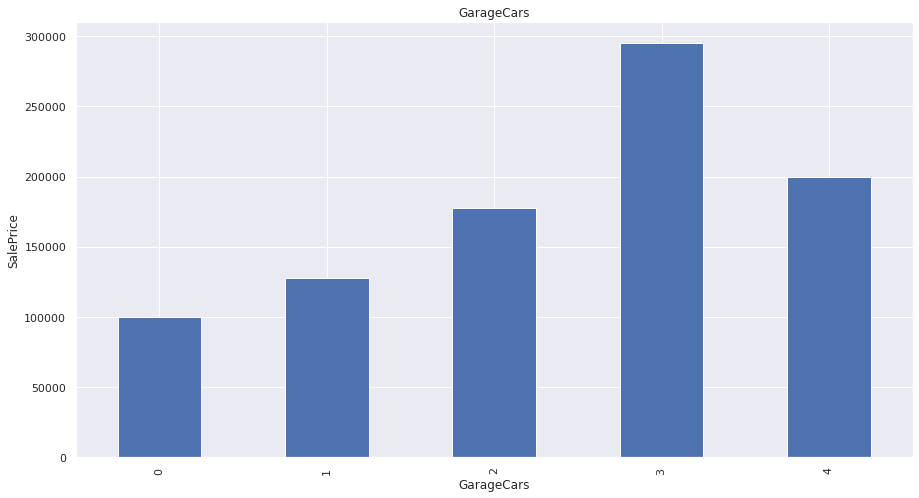

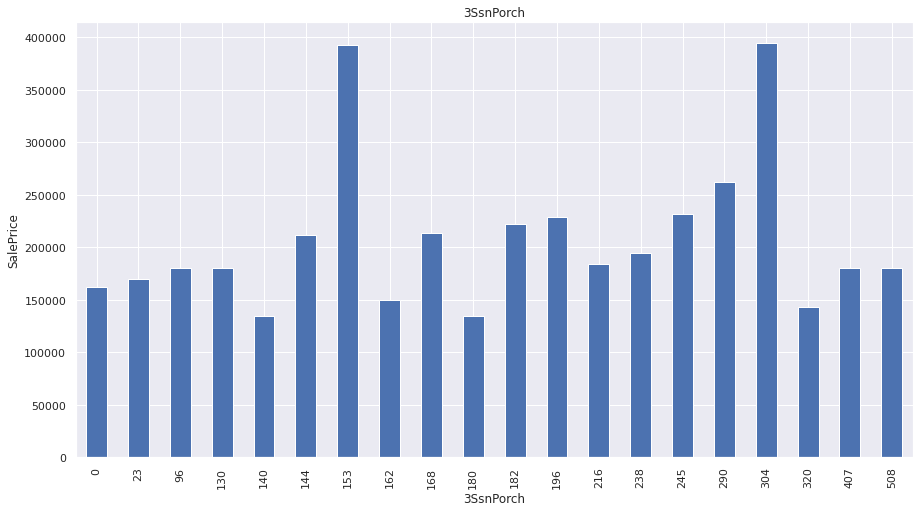

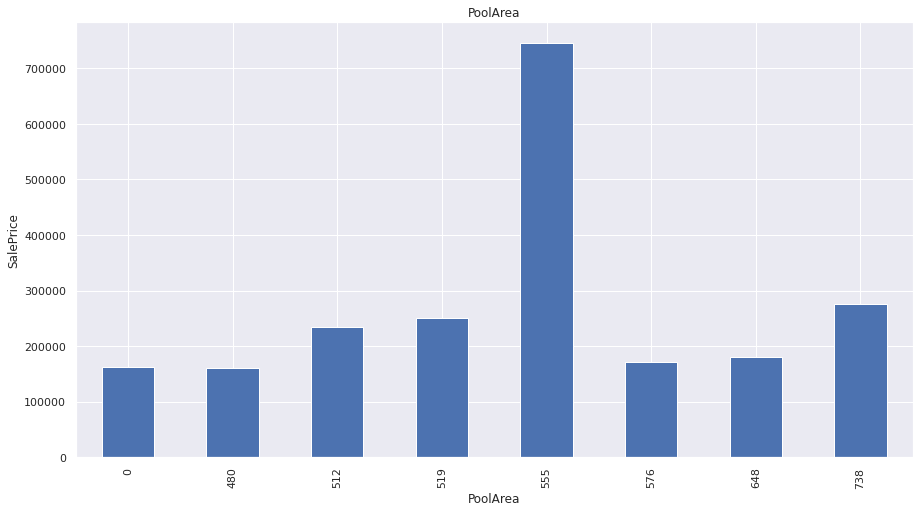

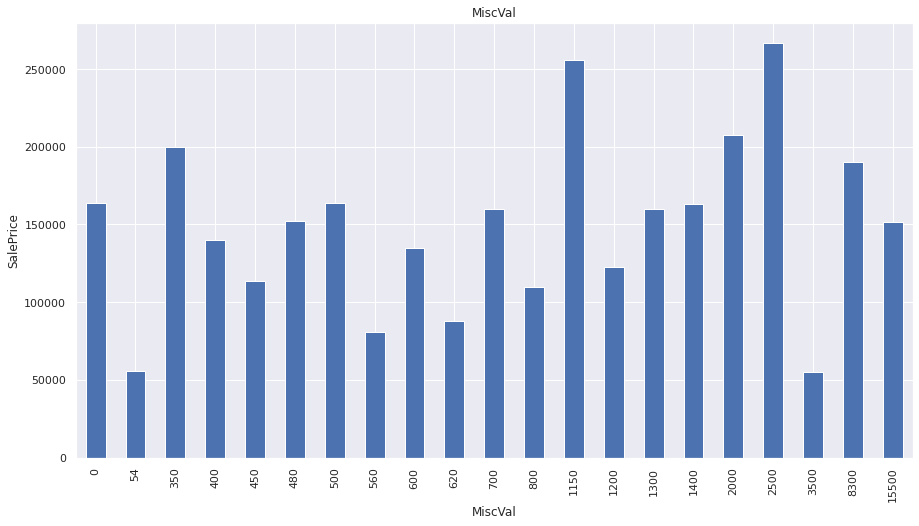

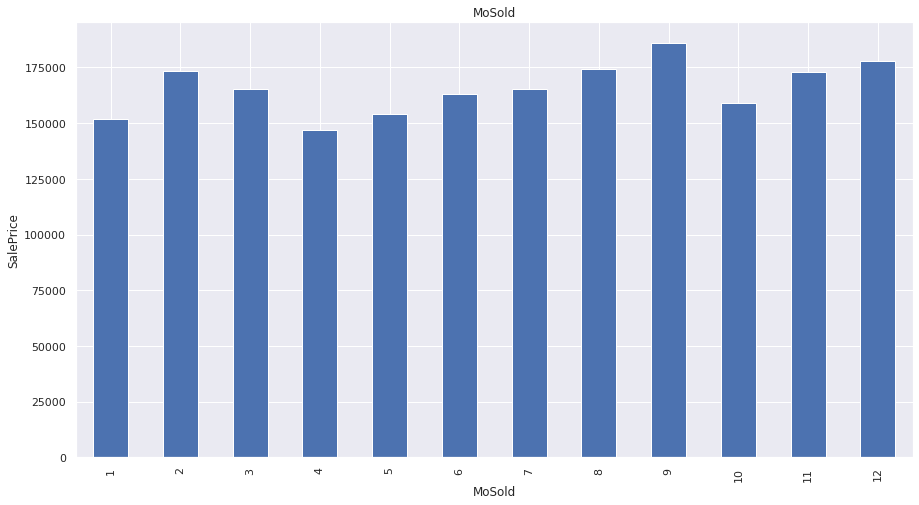

In [14]:
for feature in categ_feature:
    ax = plt.subplots(figsize=(15,8))
    df_train.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

## 3. Подготовка данных к обучению<a class="anchor" id="3-bullet"></a>
[назад к оглавлению](#0-bullet)

### 3.1 Pipeline<a class="anchor" id="3.1-bullet"></a>

Для упрощения преобразовывания данных используем модуль $Pipeline$, который позволяет упростить процесс подготовки данных
- Для заполнения отсутствующих значений дискретных и категориальных величин используем класс $Simple Imputer$
- После заполнения всех пропусков нормализируем числовые данные с использованием $Min Max Scaler$
- Категориальные данные кодируем с помощью $One Hot Encoder$

В качестве ML моделей были выбраны: 
- CatBoost
- Linear Regression
- RandomForest
- LGBMRegressor

In [46]:
for j in range(1,2):

    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    df_id = df_test['Id']
    df_train.drop(['Id'], axis=1, inplace=True)
    df_test.drop(['Id'], axis=1, inplace=True)
    df = pd.concat((df_train, df_test)).reset_index(drop=True)
    df.drop(['SalePrice'], axis=1, inplace=True)
    cat_attribs = []
    num_attribs = []

    for i in df.columns:
        if df_train[i].dtype == np.float64 or df_train[i].dtype == np.int64:
            if i != 'MSSubClass' or i != 'OverallQual' or i != 'Fireplaces':
                num_attribs.append(i)
        else:
            cat_attribs.append(i)

    cat_attribs.append('MSSubClass')
    cat_attribs.append('OverallQual')
    cat_attribs.append('Fireplaces')
    def fill_func(columns):
        for i in columns:
            df[i].fillna(f'No{i}', inplace=True)

    fill_func(['Alley', 'PoolQC', 'Fence', 'FireplaceQu', 
                         'GarageType', 'MasVnrType', 'BsmtQual', 'BsmtCond',
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MiscFeature'])
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('min_max_scaler', MinMaxScaler())
    ])

    full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), cat_attribs),
        ('cat', OneHotEncoder(drop='first'), cat_attribs)
    ])


    def log_func(num):
        return np.log1p(num)

    def exp_func(num):
        return np.expm1(num)


    df_train_ready = pd.DataFrame(full_pipeline.fit_transform(df))
    for i in range(80, 35, -1):
        df_train_ready.drop(i, axis=1, inplace=True)

    for i in range(0, 36):
        if df_train_ready[i].dtype == np.float64 or df_train_ready[i].dtype == np.int64:
            print(i)
        else:
            df_train_ready[i] = pd.to_numeric(df_train_ready[i], downcast="float")

    cat_features = []
    for i in range(81, 342):
        cat_features.append(i)
        if df_train_ready[i].dtype == np.float64 or df_train_ready[i].dtype == np.int64:
            print(i)
        else:
            df_train_ready[i] = pd.to_numeric(df_train_ready[i], downcast="float")

    df_answer = pd.read_csv(f'final_result{j}.csv')
    df_all = pd.DataFrame(data=pd.concat([df_train['SalePrice'], df_answer['SalePrice']],axis=0))
    df_all['SalePrice'] = df_all['SalePrice'].apply(log_func)


    X_train, X_test, y_train, y_test = train_test_split(df_train_ready, 
                                                        df_all['SalePrice'], 
                                                        random_state=101, 
                                                        train_size=0.99)

# learning_rate=0.03975, iterations = 1060, depth=7, verbose=False
# {'learning_rate': 0.039, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}



    cat = CatBoostRegressor(learning_rate=0.039, iterations = 2500, depth=5, min_child_samples=16, verbose=False)
    cat.fit(X_train, y_train)
    cat_pred = cat.predict(X_test)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)

    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    rfr_pred = rfr.predict(X_test)

    lgbm = LGBMRegressor(learning_rate= 0.4, max_depth=15, num_leaves = 32, subsample=0.5)
    lgbm.fit(X_train, y_train)
    lgbm_pred = lgbm.predict(X_test)

    print(f'CatBoost - {mean_squared_log_error(y_test, cat_pred, squared=False)}')
    print(f'Linear Regression - {mean_squared_log_error(y_test, lr_pred, squared=False)}')
    print(f'RandomForest - {mean_squared_log_error(y_test, rfr_pred, squared=False)}')
    print(f'LGBMRegressor - {mean_squared_log_error(y_test, lgbm_pred, squared=False)}')

    df_test = df_train_ready[1460:]
    y_pred = cat.predict(df_test)
    df_y_pred = pd.DataFrame(y_pred, columns=['SalePrice'])
    df_y_pred['SalePrice'] = df_y_pred['SalePrice'].apply(exp_func)
    df_finish = pd.concat([df_id, df_y_pred], axis=1)
    df_finish.to_csv(f'final_result{j+1}.csv', sep=',', index = False)

CatBoost - 0.005175821043949198
Linear Regression - 0.006421192178866417
RandomForest - 0.00795549445048406
LGBMRegressor - 0.0069238018256103885


In [51]:
df_X = df_train_ready
df_X.to_csv(f'df_X.csv', sep=',', index = False)

In [52]:
df_y = df_all['SalePrice']
df_y.to_csv(f'df_y.csv', sep=',', index = False)

In [56]:
df_test.to_csv(f'df_test.csv', sep=',', index = False)

In [57]:
df_id

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

## 4. Optuna<a class="anchor" id="4-bullet"></a>
[назад к оглавлению](#0-bullet)

Лучший результат CatBoost{'learning_rate': 0.039, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}

In [103]:
import optuna
from sklearn.metrics import mean_squared_log_error
RANDOM_SEED = 1

def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.03, 0.05, 0.001)
    param['depth'] = trial.suggest_int('depth', 2, 10)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 11, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = trial.suggest_int('iterations', 2500, 10500, 500)
    param['use_best_model'] = True
    param['eval_metric'] = 'MSLE'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'

    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_test.copy(), y_test.copy())])
    loss = mean_squared_log_error(y_test, regressor.predict(X_test.copy()))
    return loss

study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=500, n_jobs=-1, timeout=24000)

[I 2022-01-28 11:49:03,327] A new study created in memory with name: catboost-seed1
/Users/viktorkuvsinov/opt/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger

[I 2022-01-28 11:49:27,491] Trial 18 finished with value: 3.0329182911490523e-05 and parameters: {'learning_rate': 0.045, 'depth': 9, 'min_child_samples': 8, 'iterations': 10500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:49:27,494] Trial 37 finished with value: 2.781430225045565e-05 and parameters: {'learning_rate': 0.034999999999999996, 'depth': 4, 'min_child_samples': 16, 'iterations': 9000}. Best is trial 11 with value: 2.419565608997345e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:49:27,733] Trial 10 finished with value: 3.134890762533457e-05 and parameters: {'learning_rate': 0.034, 'depth': 9, 'min_child_samples': 4, 'iterations': 4000}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:49:29,474] Trial 39 finished with value: 3.1896471756996946e-05 and parameters: {'learning_rate': 0.034999999999999996, 'depth': 3, 'min_child_samples': 16, 'iterations': 9000}. 

[I 2022-01-28 11:49:46,990] Trial 31 finished with value: 3.140745985054438e-05 and parameters: {'learning_rate': 0.034, 'depth': 10, 'min_child_samples': 8, 'iterations': 4500}. Best is trial 11 with value: 2.419565608997345e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:49:47,590] Trial 38 finished with value: 3.479506324099465e-05 and parameters: {'learning_rate': 0.034, 'depth': 10, 'min_child_samples': 16, 'iterations': 9500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:49:47,953] Trial 60 finished with value: 3.185520009589552e-05 and parameters: {'learning_rate': 0.033, 'depth': 6, 'min_child_samples': 4, 'iterations': 10500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:49:48,362] Trial 68 finished with value: 2.9770869823839876e-05 and parameters: {'learning_rate': 0.034, 'depth': 4, 'min_child_samples': 4, 'iterations': 4500}. Best is trial 11 with value: 2

[I 2022-01-28 11:50:00,995] Trial 94 finished with value: 3.699528646177407e-05 and parameters: {'learning_rate': 0.039, 'depth': 7, 'min_child_samples': 11, 'iterations': 3000}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:01,137] Trial 92 finished with value: 3.3012172830710574e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 7, 'min_child_samples': 16, 'iterations': 3000}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:02,365] Trial 97 finished with value: 3.3231328815627586e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 7, 'min_child_samples': 8, 'iterations': 3000}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:02,669] Trial 83 finished with value: 3.3519330869751894e-05 and parameters: {'learning_rate': 0.043, 'depth': 9, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:03,987] Trial 89 finishe

[I 2022-01-28 11:50:12,889] Trial 93 finished with value: 2.9313056828896574e-05 and parameters: {'learning_rate': 0.039, 'depth': 9, 'min_child_samples': 11, 'iterations': 3000}. Best is trial 11 with value: 2.419565608997345e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:50:13,430] Trial 121 finished with value: 2.7817181055700842e-05 and parameters: {'learning_rate': 0.038, 'depth': 2, 'min_child_samples': 16, 'iterations': 8500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:13,887] Trial 100 finished with value: 3.7705976473385385e-05 and parameters: {'learning_rate': 0.039, 'depth': 9, 'min_child_samples': 8, 'iterations': 4000}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:13,895] Trial 99 finished with value: 4.1628104962693846e-05 and parameters: {'learning_rate': 0.031, 'depth': 9, 'min_child_samples': 11, 'iterations': 3000}. Best is trial 11 with valu

[I 2022-01-28 11:50:19,993] Trial 148 finished with value: 3.429408330785796e-05 and parameters: {'learning_rate': 0.049, 'depth': 3, 'min_child_samples': 16, 'iterations': 8500}. Best is trial 11 with value: 2.419565608997345e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:50:20,403] Trial 146 finished with value: 3.483160809905271e-05 and parameters: {'learning_rate': 0.047, 'depth': 3, 'min_child_samples': 16, 'iterations': 8500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:20,406] Trial 145 finished with value: 3.483160809905271e-05 and parameters: {'learning_rate': 0.047, 'depth': 3, 'min_child_samples': 16, 'iterations': 8500}. Best is trial 11 with value: 2.419565608997345e-05.
[I 2022-01-28 11:50:20,439] Trial 144 finished with value: 3.483160809905271e-05 and parameters: {'learning_rate': 0.047, 'depth': 3, 'min_child_samples': 16, 'iterations': 8500}. Best is trial 11 with value

[I 2022-01-28 11:50:26,178] Trial 173 finished with value: 2.6956563238701305e-05 and parameters: {'learning_rate': 0.036, 'depth': 2, 'min_child_samples': 16, 'iterations': 7000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:26,181] Trial 174 finished with value: 2.6956563238701305e-05 and parameters: {'learning_rate': 0.036, 'depth': 2, 'min_child_samples': 16, 'iterations': 7000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:26,200] Trial 175 finished with value: 2.6956563238701305e-05 and parameters: {'learning_rate': 0.036, 'depth': 2, 'min_child_samples': 16, 'iterations': 7000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:26,268] Trial 177 finished with value: 2.7376844386239918e-05 and parameters: {'learning_rate': 0.05, 'depth': 2, 'min_child_samples': 16, 'iterations': 6000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:26,489] Trial 176 finished with value: 2.6735

[I 2022-01-28 11:50:34,072] Trial 201 finished with value: 3.2397767025024396e-05 and parameters: {'learning_rate': 0.04, 'depth': 5, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:34,114] Trial 200 finished with value: 3.2397767025024396e-05 and parameters: {'learning_rate': 0.04, 'depth': 5, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:34,117] Trial 202 finished with value: 3.2397767025024396e-05 and parameters: {'learning_rate': 0.04, 'depth': 5, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:50:34,563] Trial 204 finished with value: 3.2397767025024396e-05 and parameters: {'learnin

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:50:40,838] Trial 227 finished with value: 3.106100086774202e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 11, 'iterations': 4000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:40,855] Trial 228 finished with value: 3.106100086774202e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 11, 'iterations': 4000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:40,941] Trial 229 finished with value: 3.106100086774202e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 11, 'iterations': 4000}. Best is trial 166 with value: 2.394321697702969e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom log

[I 2022-01-28 11:50:48,407] Trial 254 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 4500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:48,411] Trial 258 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 4500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:48,412] Trial 248 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 4500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:50:48,416] Trial 250 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 4500}. Best is trial 166 with value: 2.394321697702969e-05.
Custom logger is already specified. Specify more than one logger

[I 2022-01-28 11:51:03,823] Trial 310 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:03,835] Trial 303 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:03,836] Trial 304 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:51:03,842] Trial 307 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value

[I 2022-01-28 11:51:10,894] Trial 330 finished with value: 3.345281936650037e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 3, 'min_child_samples': 32, 'iterations': 3000}. Best is trial 166 with value: 2.394321697702969e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:51:11,012] Trial 332 finished with value: 2.6473346277780944e-05 and parameters: {'learning_rate': 0.04, 'depth': 2, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:11,420] Trial 333 finished with value: 2.6473346277780944e-05 and parameters: {'learning_rate': 0.04, 'depth': 2, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:11,436] Trial 334 finished with value: 2.6473346277780944e-05 and parameters: {'learning_rate': 0.04, 'depth': 2, 'min_child_samples': 16, 'iterations': 3500}. Best is t

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:51:19,561] Trial 357 finished with value: 3.5108481370135785e-05 and parameters: {'learning_rate': 0.04, 'depth': 6, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:19,813] Trial 358 finished with value: 3.005972648045113e-05 and parameters: {'learning_rate': 0.032, 'depth': 5, 'min_child_samples': 16, 'iterations': 3500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:19,945] Trial 360 finished wi

[I 2022-01-28 11:51:27,804] Trial 385 finished with value: 3.080821461923726e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 4, 'min_child_samples': 16, 'iterations': 4500}. Best is trial 166 with value: 2.394321697702969e-05.
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-28 11:51:27,831] Trial 379 finished with value: 3.080821461923726e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 4, 'min_child_samples': 16, 'iterations': 3000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:27,911] Trial 387 finished with value: 3.080821461923726e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 4, 'min_child_samples': 16, 'iterations': 4500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:27,913] Trial 381 finished with value: 3.080821461923726e-05 and parameters: {'learning_rate': 0.040999999999999995, 'depth': 4, 'min_child

[I 2022-01-28 11:51:43,979] Trial 437 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 2500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:43,991] Trial 438 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 5000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:44,010] Trial 440 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 5500}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:44,030] Trial 434 finished with value: 2.394321697702969e-05 and parameters: {'learning_rate': 0.04, 'depth': 4, 'min_child_samples': 16, 'iterations': 5000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:44,037] Trial 441 finished with value: 2.39432169770

[I 2022-01-28 11:51:59,583] Trial 484 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 5000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:59,597] Trial 480 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 5000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:59,611] Trial 482 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 5000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:59,614] Trial 483 finished with value: 2.5486342529043018e-05 and parameters: {'learning_rate': 0.039, 'depth': 4, 'min_child_samples': 16, 'iterations': 5000}. Best is trial 166 with value: 2.394321697702969e-05.
[I 2022-01-28 11:51:59,725] Trial 481 finished with value: 2.548

In [95]:
print(study.best_params)

{'learning_rate': 0.039, 'depth': 5, 'l2_leaf_reg': 2.0, 'min_child_samples': 16}


## 5. Итоги<a class="anchor" id="5-bullet"></a>
[назад к оглавлению](#0-bullet)

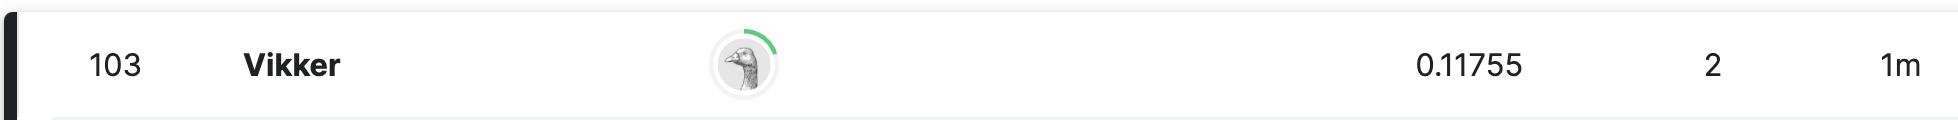

In [15]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import _get_covariance,anova_lm 
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
from statsmodels.stats.multicomp import MultiComparison 
sns.set()

In [16]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

In [17]:
categ_feature = ['MSSubClass','OverallQual','OverallCond','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars', 'PoolArea','MiscVal','MoSold']

In [18]:
for feature in categ_feature:
    formula = f'SalePrice ~ C({feature})'
    model = ols(formula, df_train).fit()
    aov_table = anova_lm(model)
    print(aov_table)

                   df        sum_sq       mean_sq          F        PR(>F)
C(MSSubClass)    14.0  2.268056e+12  1.620040e+11  33.732076  8.662166e-79
Residual       1445.0  6.939856e+12  4.802668e+09        NaN           NaN
                    df        sum_sq       mean_sq          F  PR(>F)
C(OverallQual)     9.0  6.299881e+12  6.999867e+11  349.02684     0.0
Residual        1450.0  2.908031e+12  2.005538e+09        NaN     NaN
                    df        sum_sq       mean_sq          F        PR(>F)
C(OverallCond)     8.0  1.154581e+12  1.443226e+11  26.003173  7.962289e-38
Residual        1451.0  8.053330e+12  5.550193e+09        NaN           NaN
                     df        sum_sq       mean_sq         F    PR(>F)
C(LowQualFinSF)    23.0  1.703278e+11  7.405558e+09  1.176684  0.255656
Residual         1436.0  9.037584e+12  6.293582e+09       NaN       NaN
                     df        sum_sq       mean_sq          F        PR(>F)
C(BsmtFullBath)     3.0  4.928785e+11  1.642

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     26.00
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           7.96e-38
Time:                        16:19:11   Log-Likelihood:                -18446.
No. Observations:                1460   AIC:                         3.691e+04
Df Residuals:                    1451   BIC:                         3.696e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              6.1e+04   7.45e+04      0.819      0.413   -8.51e+04    2.07e+05
C(OverallCond)[T.2]  8.099e+04   8.16e+04      0.992      0.321   -7.91e+04    2.41e+05
C(OverallCond)[T.3]  4.093e+04    7.6e+04      0.539      0.590   -1.08e+05     1.9e+05
C(OverallCond)[T.4]  5.944e+04   7.52e+04      0.791      0.429    -8.8e+04    2.07e+05
C(OverallCond)[T.5]  1.421e+05   7.45e+04      1.907      0.057   -4080.529    2.88e+05
C(OverallCond)[T.6]  9.296e+04   7.46e+04      1.245      0.213   -5.35e+04    2.39e+05
C(OverallCond)[T.7]  9.715e+04   7.47e+04      1.301      0.194   -4.93e+04    2.44e+05
C(OverallCond)[T.8]  9.465e+04    7.5e+04      1.262      0.207   -5.25e+04    2.42e+05
C(OverallCond)[T.9]   1.55e+05   7.62e+04      2.035      0.042    5581.655    3.04e+05
==============================================================================
Omnibus:                      647.940   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4639.706
Skew:                           1.923   Prob(JB):                         0.00
Kurtosis:                      10.841   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
df_train = pd.read_csv('train.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_id = df_test['Id']
df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)
df = pd.concat((df_train, df_test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)
cat_attribs = []
num_attribs = []

for i in df.columns:
    if df_train[i].dtype == np.float64 or df_train[i].dtype == np.int64:
        if i != 'MSSubClass' or i != 'OverallQual' or i != 'Fireplaces':
            num_attribs.append(i)
    else:
        cat_attribs.append(i)

cat_attribs.append('MSSubClass')
cat_attribs.append('OverallQual')
cat_attribs.append('Fireplaces')
def fill_func(columns):
    for i in columns:
        df[i].fillna(f'No{i}', inplace=True)

fill_func(['Alley', 'PoolQC', 'Fence', 'FireplaceQu', 
                     'GarageType', 'MasVnrType', 'BsmtQual', 'BsmtCond',
                    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MiscFeature'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for y in cat_attribs:
    le.fit(df[y])
    df[y] = le.transform(df[y])
    

def log_func(num):
    return np.log1p(num)

def exp_func(num):
    return np.expm1(num)


df_train['SalePrice'] = df_train['SalePrice'].apply(log_func)

df_test = df[1460:]
df_t = df[:1460]

X_train, X_test, y_train, y_test = train_test_split(df_t, 
                                                    df_train['SalePrice'], 
                                                    random_state=101, 
                                                    train_size=0.99)

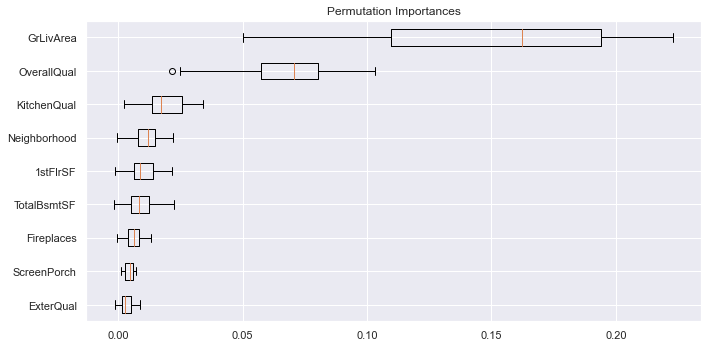

In [37]:
from sklearn.inspection import permutation_importance

cat = CatBoostRegressor(learning_rate=0.041, iterations = 1060, depth=7, 
                        verbose=False, min_child_samples=4, cat_features=cat_attribs)
cat.fit(X_train, y_train)

r = permutation_importance(cat, X_test, y_test,
                           n_repeats=30,
                           random_state=0)
sorted_idx = r.importances_mean.argsort()
sorted_idx = sorted_idx[70::]

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(
    r.importances[sorted_idx].T, vert=False, labels=df.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()